# Scaling Elastic Wave Equations from Virieux 1986

In [35]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

### Implementing unscaled constant parameter propagation

In [36]:
# Set up the grid
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# Create the velocity and stress fields
# space order 4 is the sweet spot
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=4, time_order=1)
tau = dv.TensorTimeFunction(name='tau', grid=grid, space_order=4, time_order=1)

# Define constants
constants = {
    "vp": 3,
    "vs": 1.5,
    "density": 2.4,
    "f0": 0.03
}

# Find dt using CFL condition
vmax = max(constants['vp'], constants['vs'])
dt = np.amin(grid.spacing) * 0.6 / vmax

# Define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Create the source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)

# Setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# Source term injections
src_xx = src.inject(field=tau[0, 0].forward, expr=src)
src_zz = src.inject(field=tau[1, 1].forward, expr=src)
src_xz = src.inject(field=tau[0, 1].forward, expr=src)

# define equations
eq_v = v.dt - 1/constants["density"]*dv.div(tau)
eq_tau = tau.dt - constants["density"] * (constants["vp"]**2 - 2 * constants["vs"]**2) * dv.diag(dv.div(v.forward)) - constants["density"] * constants["vs"]**2 * (dv.grad(v.forward) + dv.grad(v.forward).transpose(inner=False))

# Define stencils
stencil_v = dv.Eq(v.forward, dv.solve(eq_v, v.forward))
stencil_tau = dv.Eq(tau.forward, dv.solve(eq_tau, tau.forward))

# Set up the operator and run the simulation
op = dv.Operator([stencil_v, stencil_tau] + src_xx + src_zz)
op(dt=dt)


Operator `Kernel` ran in 0.04 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.03461199999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

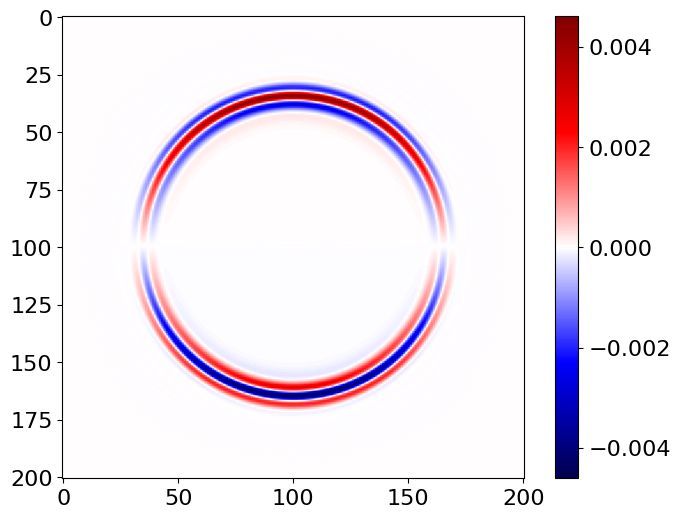

In [37]:
vmax = np.amax(np.abs(v[0].data[0]))
plt.imshow(v[0].data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

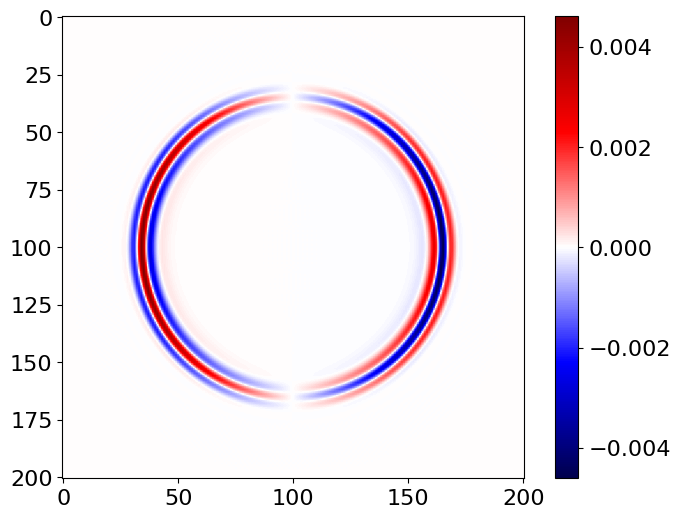

In [38]:
vmax = np.amax(np.abs(v[1].data[0]))
plt.imshow(v[1].data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

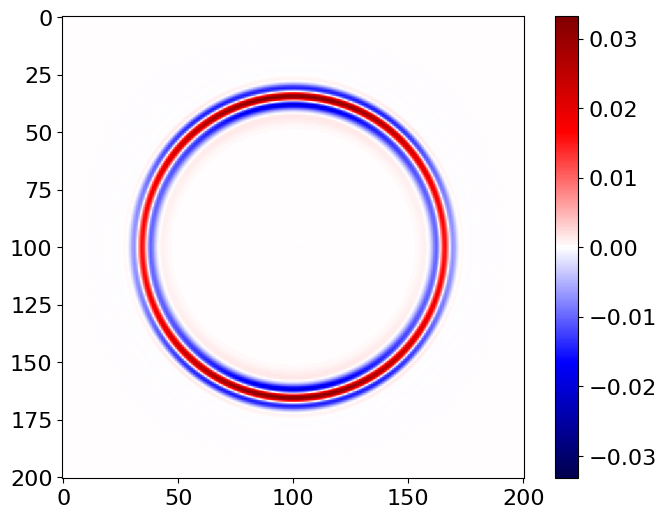

In [39]:
vmax = np.amax(np.abs(tau[0, 0].data[0]))
plt.imshow(tau[0, 0].data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

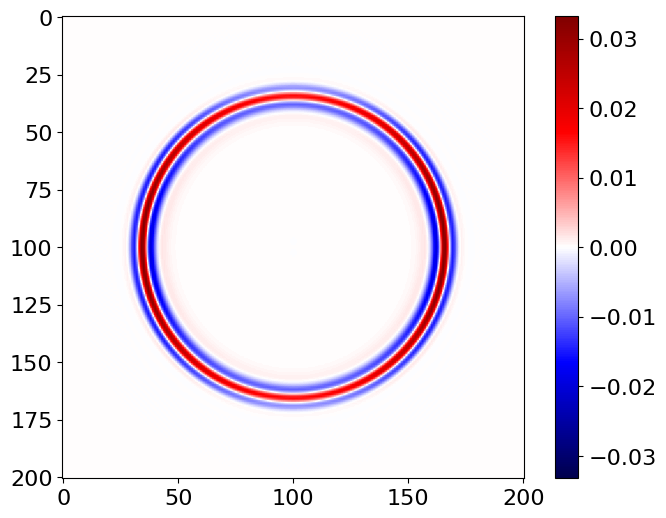

In [40]:
vmax = np.amax(np.abs(tau[1, 1].data[0]))
plt.imshow(tau[1, 1].data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

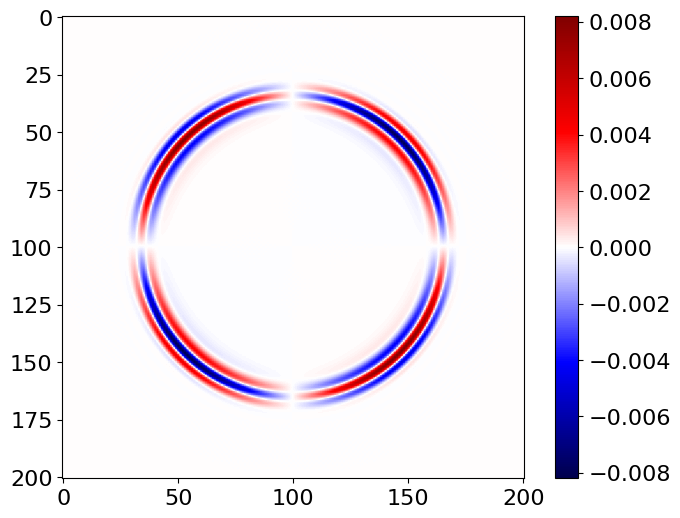

In [41]:
vmax = np.amax(np.abs(tau[0, 1].data[0]))
plt.imshow(tau[0, 1].data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

### Creating a variable parameter model

<div style="text-align: center;">
    <img src="Figures\elastic-variable-model.png" alt="Velocity Model" style="width:1000px; margin: 20px;"/>
</div>

In [42]:
# Create spatial fields for Vp, Vs, and density
Vp = dv.Function(name="Vp", grid=grid)
Vs = dv.Function(name="Vs", grid=grid)
rho = dv.Function(name="rho", grid=grid)

# Define layer interfaces (in grid points)
layer1_depth = int(shape[0] / 4)  # 1st layer: top 1/4th of the model
layer2_depth = int(shape[0] / 2)  # 2nd layer: next 1/4th
layer3_depth = int(3 * shape[0] / 4)  # 3rd layer: next 1/4th
layer4_depth = shape[0]  # 4th layer: bottom 1/4th

# Assign values for each layer
# Layer 1 (water-like)
Vp.data[:layer1_depth, :] = 1500  # m/s
Vs.data[:layer1_depth, :] = 0  # m/s (water-like)
rho.data[:layer1_depth, :] = 1000  # kg/m^3

# Layer 2
Vp.data[layer1_depth:layer2_depth, :] = 2000  # m/s
Vs.data[layer1_depth:layer2_depth, :] = 800  # m/s
rho.data[layer1_depth:layer2_depth, :] = 2000  # kg/m^3

# Layer 3
Vp.data[layer2_depth:layer3_depth, :] = 3000  # m/s
Vs.data[layer2_depth:layer3_depth, :] = 1500  # m/s
rho.data[layer2_depth:layer3_depth, :] = 2500  # kg/m^3

# Layer 4
Vp.data[layer3_depth:layer4_depth, :] = 4000  # m/s
Vs.data[layer3_depth:layer4_depth, :] = 2000  # m/s
rho.data[layer3_depth:layer4_depth, :] = 3000  # kg/m^3


### Implementing unscaled variable parameter propagation

In [43]:
# create new functions to store velocity and stress
v_v = dv.VectorTimeFunction(name='v_v', grid=grid, space_order=4, time_order=1)
tau_v = dv.TensorTimeFunction(name='tau_v', grid=grid, space_order=4, time_order=1)

# define dictionary for physical parameters in SI units
parameters = {
    'vp': Vp,
    'vs': Vs,
    'density': rho,
    'f0': 30,
    'tn': 0.25
}

# calculate the maximum velocity to find timestep - the Vp field will contain this
vmax = float(np.max(Vp.data))
dt = float(np.amin(grid.spacing) * 0.6 / vmax)

# define a time range for the source term
t0 = 0
tn = parameters['tn']
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term
src = RickerSource(name='src', grid=grid, f0=parameters["f0"], npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# Source term injections
src_xx = src.inject(field=tau_v[0, 0].forward, expr=src)
src_zz = src.inject(field=tau_v[1, 1].forward, expr=src)
src_xz = src.inject(field=tau_v[0, 1].forward, expr=src)

# define equations with new velocities
eq_v_v = v_v.dt - 1/parameters["density"]*dv.div(tau_v)
eq_tau_v = tau_v.dt - parameters["density"] * (parameters["vp"]**2 - 2 * parameters["vs"]**2) * dv.diag(dv.div(v_v.forward)) - parameters["density"] * parameters["vs"]**2 * (dv.grad(v_v.forward) + dv.grad(v_v.forward).transpose(inner=False))

# Define stencils
stencil_v_v = dv.Eq(v_v.forward, dv.solve(eq_v_v, v_v.forward))
stencil_tau_v = dv.Eq(tau_v.forward, dv.solve(eq_tau_v, tau_v.forward))

# Set up the operator and run the simulation
op = dv.Operator([stencil_v_v, stencil_tau_v] + src_xx + src_zz)
op(dt=dt)


Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0791999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1.1000000000000001e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

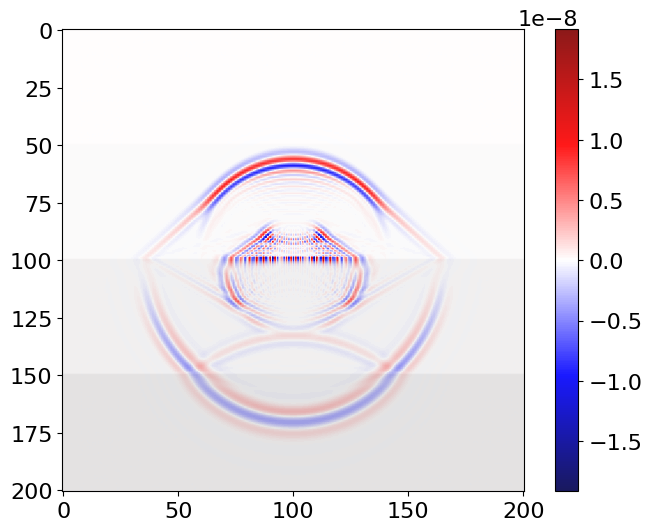

In [44]:
vmax = np.amax(np.abs(v_v[0].data[0]))
plt.imshow(Vp.data, cmap='Greys')
plt.imshow(v_v[0].data[0], cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.9)
plt.colorbar()
plt.show()

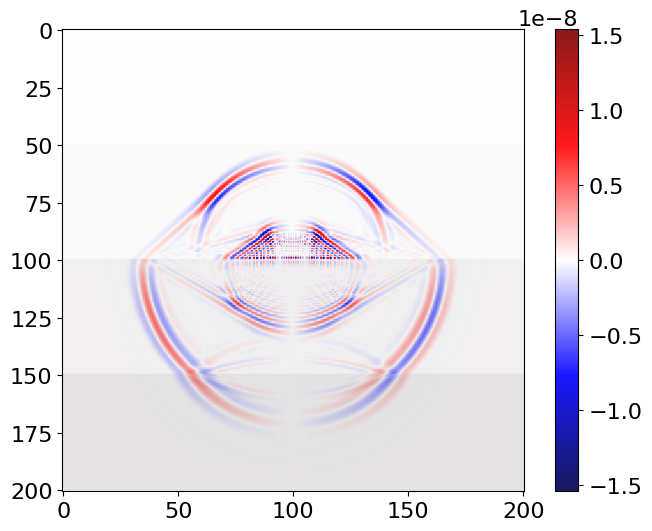

In [45]:
vmax = np.amax(np.abs(v_v[1].data[0]))
plt.imshow(Vp.data, cmap='Greys')
plt.imshow(v_v[1].data[0], cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.9)
plt.colorbar()
plt.show()

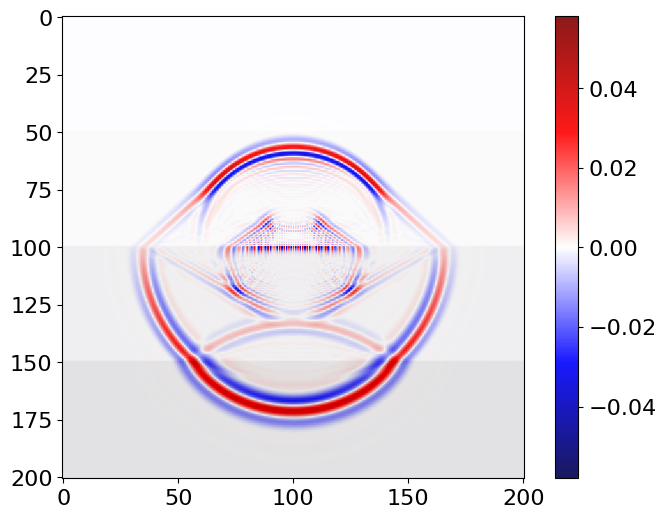

In [46]:
vmax = np.amax(np.abs(tau_v[0, 0].data[0]))
plt.imshow(Vp.data, cmap='Greys')
plt.imshow(tau_v[0, 0].data[0], cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.9)
plt.colorbar()
plt.show()

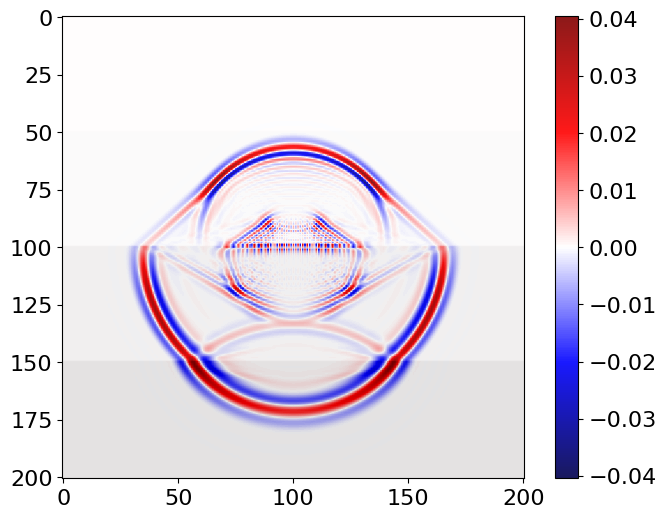

In [47]:
vmax = np.amax(np.abs(tau_v[1, 1].data[0]))
plt.imshow(Vp.data, cmap='Greys')
plt.imshow(tau_v[1, 1].data[0], cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.9)
plt.colorbar()
plt.show()

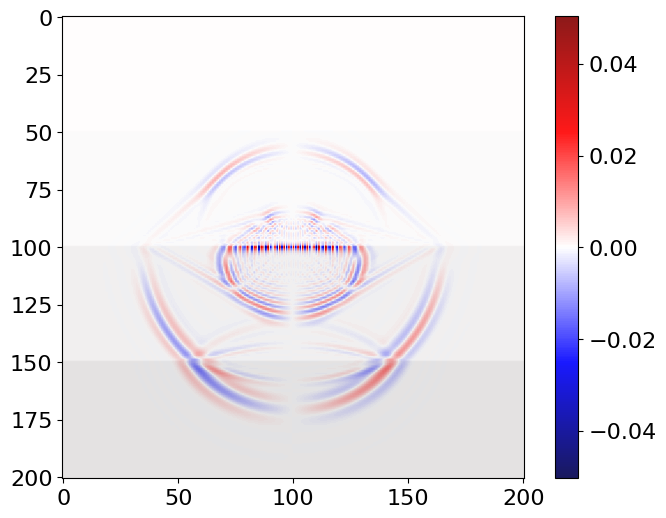

In [48]:
vmax = np.amax(np.abs(tau_v[0, 1].data[0]))
plt.imshow(Vp.data, cmap='Greys')
plt.imshow(tau_v[0, 1].data[0], cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.9)
plt.colorbar()
plt.show()